In [1]:
import numpy as np
import matplotlib.pyplot as plt

import keras
from keras import backend as K
from keras import layers, models

from encoding import Encoding

Using TensorFlow backend.


In [2]:
keras.__version__, K.tf.__version__

('2.2.0', '1.8.0')

## Toy Setup Demo

In [6]:
k = 3        # number of codewords to learn
h, w = 4,5   # conv filter dims (feature vectors)
d = 12       # number of conv filters (features)

conv_input = layers.Input(shape=(h,w,d,), name='features')

# D is automatically inferred
E = Encoding(k, name='encoding')(conv_input)

simple_enc = models.Model(inputs=conv_input, outputs=E)
simple_enc.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
features (InputLayer)        (None, 4, 5, 12)          0         
_________________________________________________________________
encoding (Encoding)          (None, 3, 12)             39        
Total params: 39
Trainable params: 39
Non-trainable params: 0
_________________________________________________________________


In [7]:
x = np.random.random(size=(h,w,d))
print(x.shape)

x_encoded = simple_enc.predict_on_batch(x[np.newaxis,...])
print(x_encoded.shape)

(4, 5, 12)
(1, 3, 12)


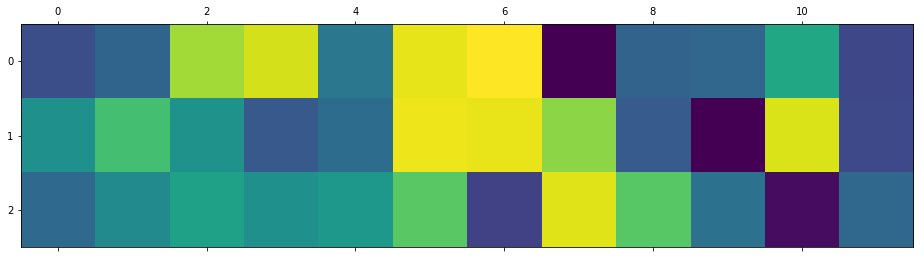

In [8]:
# Visualize the initial codebook
plt.matshow(simple_enc.get_layer('encoding').get_weights()[0])

## Pre-trained Conv Features Demo

In [10]:
from keras.applications import vgg19

In [11]:
# shouldn't need an input_shape, but we'll try this for demo
vgg19_base = vgg19.VGG19(include_top=False, input_shape=(448,448,3))

print(vgg19_base.output_shape)

(None, 14, 14, 512)


In [12]:
x = vgg19_base.output
x = layers.Conv2D(128, (1, 1), activation='relu')(x) # 1x1 conv (512-->128)

k = 10
x = Encoding(10, name='encoding')(x)
x = layers.Flatten()(x)
preds = layers.Dense(10, activation='softmax')(x)

img_encode = models.Model(inputs=vgg19_base.input, outputs=preds)

In [13]:
img_encode.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 448, 448, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 448, 448, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 448, 448, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 224, 224, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 224, 224, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 224, 224, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 112, 112, 128)     0         
__________

In [14]:
# Random batch of 16
x = np.random.random(size=(16,448,448,3))

pred = img_encode.predict(x, batch_size=x.shape[0])
print(pred.shape)

(16, 10)


### Make sure training works (Flickr Materials Database)

In [15]:
import glob
from skimage import io
from skimage.color import gray2rgb
from skimage.transform import resize

from sklearn.model_selection import train_test_split

from keras import utils
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [16]:
def square(img):
    # naive version -- not centered
    if img.ndim == 2:
        img = gray2rgb(img)
    h, w, _ = img.shape
    s = min(h, w)
    return img[0:s,0:s,:]

def sqr_resize(img_file):
    img = square(io.imread(img_file))
    return resize(img, (448,448))

flickr_dir = '/home/ross/Dropbox/benchmark/FlickrMaterials/image/'
classes = ['fabric', 'foliage', 'glass', 'leather', 'metal',
            'paper', 'plastic', 'stone', 'water', 'wood']

imgs = []
labels = []
for i, cls in enumerate(classes):
    img_files = glob.glob(flickr_dir+cls+'/*jpg')
    imgs.append(np.array([sqr_resize(jpg) for jpg in img_files]))
    labels.append(np.array([i]*len(img_files)))

X = np.concatenate(imgs)
y = np.concatenate(labels)
print(X.shape, y.shape)

/home/ross/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


(1000, 448, 448, 3) (1000,)


In [17]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2,
                                                 random_state=27, stratify=y)

train_gen = ImageDataGenerator(width_shift_range=0.25,
                              height_shift_range=0.25,
                              shear_range=-45.0,
                              zoom_range=0.5,
                              horizontal_flip=True,
                              vertical_flip=True,
                              preprocessing_function=vgg19.preprocess_input)
val_gen = ImageDataGenerator(preprocessing_function=vgg19.preprocess_input)
train_gen.fit(X_train)
val_gen.fit(X_val)

In [18]:
y_train = utils.to_categorical(y_train, 10)
y_val = utils.to_categorical(y_val, 10)

print('Training label counts: ', np.sum(y_train, axis=0))
print('Validate label counts: ', np.sum(y_val, axis=0))

Training label counts:  [80. 80. 80. 80. 80. 80. 80. 80. 80. 80.]
Validate label counts:  [20. 20. 20. 20. 20. 20. 20. 20. 20. 20.]


In [19]:
for layer in vgg19_base.layers:
    layer.trainable = False

# start with higher learning rate ?
sgd = optimizers.SGD(lr=0.1, decay=1e-4)
img_encode.compile(optimizer=sgd,
            loss='categorical_crossentropy',
            metrics=['accuracy'])

In [20]:
epochs = 500
batch_size = 16

CHKPT_PATH = './benchmark_models/flickr_vgg19_k32_d128.hdf5'
checkpoint = ModelCheckpoint(CHKPT_PATH, monitor='val_loss', save_best_only=True)
early_stop = EarlyStopping(monitor='val_loss', patience=50)

train_flow = train_gen.flow(X_train, y_train, batch_size=batch_size)
val_flow = val_gen.flow(X_val, y_val, batch_size=batch_size)

# Training
history = img_encode.fit_generator(train_flow,
                        steps_per_epoch=len(X_train)/batch_size,
                        validation_data=val_flow,
                        validation_steps=len(X_val)/batch_size,
                        callbacks=[early_stop, checkpoint], verbose=1, epochs=epochs)

Epoch 1/500
50/50 [==============================] - 31s 630ms/step - loss: 2.3354 - acc: 0.0813 - val_loss: 2.3080 - val_acc: 0.1000
Epoch 2/500
50/50 [==============================] - 26s 528ms/step - loss: 2.3285 - acc: 0.0775 - val_loss: 2.3164 - val_acc: 0.1000
Epoch 3/500
50/50 [==============================] - 28s 559ms/step - loss: 2.3251 - acc: 0.0813 - val_loss: 2.3157 - val_acc: 0.1000
Epoch 4/500
50/50 [==============================] - 28s 565ms/step - loss: 2.3236 - acc: 0.1000 - val_loss: 2.3142 - val_acc: 0.1000
Epoch 5/500
50/50 [==============================] - 28s 566ms/step - loss: 2.3244 - acc: 0.1000 - val_loss: 2.3145 - val_acc: 0.1000
Epoch 6/500
50/50 [==============================] - 29s 576ms/step - loss: 2.3210 - acc: 0.1062 - val_loss: 2.3239 - val_acc: 0.1000
Epoch 7/500
50/50 [==============================] - 28s 564ms/step - loss: 2.3238 - acc: 0.1000 - val_loss: 2.3159 - val_acc: 0.1000
Epoch 8/500
50/50 [==============================] - 28s 560ms

Epoch 62/500
50/50 [==============================] - 28s 564ms/step - loss: 2.3180 - acc: 0.0887 - val_loss: 2.2847 - val_acc: 0.1050
Epoch 63/500
50/50 [==============================] - 28s 561ms/step - loss: 2.3087 - acc: 0.1037 - val_loss: 2.2851 - val_acc: 0.1400
Epoch 64/500
50/50 [==============================] - 28s 565ms/step - loss: 2.3025 - acc: 0.1013 - val_loss: 2.2842 - val_acc: 0.1100
Epoch 65/500
50/50 [==============================] - 28s 565ms/step - loss: 2.3085 - acc: 0.1087 - val_loss: 2.2853 - val_acc: 0.1400
Epoch 66/500
50/50 [==============================] - 28s 565ms/step - loss: 2.3044 - acc: 0.1025 - val_loss: 2.2954 - val_acc: 0.1000
Epoch 67/500
50/50 [==============================] - 30s 591ms/step - loss: 2.3049 - acc: 0.1075 - val_loss: 2.2781 - val_acc: 0.1300
Epoch 68/500
50/50 [==============================] - 30s 593ms/step - loss: 2.3094 - acc: 0.0988 - val_loss: 2.2766 - val_acc: 0.1250
Epoch 69/500
50/50 [==============================] - 2

50/50 [==============================] - 28s 563ms/step - loss: 2.2518 - acc: 0.1225 - val_loss: 2.2200 - val_acc: 0.1600
Epoch 183/500
50/50 [==============================] - 28s 559ms/step - loss: 2.2685 - acc: 0.1413 - val_loss: 2.2337 - val_acc: 0.1350
Epoch 184/500
50/50 [==============================] - 28s 559ms/step - loss: 2.2628 - acc: 0.1325 - val_loss: 2.2210 - val_acc: 0.1550
Epoch 185/500
50/50 [==============================] - 28s 557ms/step - loss: 2.2533 - acc: 0.1487 - val_loss: 2.2231 - val_acc: 0.1400
Epoch 186/500
50/50 [==============================] - 28s 563ms/step - loss: 2.2555 - acc: 0.1350 - val_loss: 2.2245 - val_acc: 0.1600
Epoch 187/500
50/50 [==============================] - 29s 573ms/step - loss: 2.2662 - acc: 0.1450 - val_loss: 2.2175 - val_acc: 0.1300
Epoch 188/500
50/50 [==============================] - 28s 568ms/step - loss: 2.2474 - acc: 0.1475 - val_loss: 2.2118 - val_acc: 0.1750
Epoch 189/500
50/50 [==============================] - 29s 572

50/50 [==============================] - 28s 563ms/step - loss: 2.2287 - acc: 0.1400 - val_loss: 2.2583 - val_acc: 0.1550
Epoch 303/500
50/50 [==============================] - 28s 563ms/step - loss: 2.2512 - acc: 0.1638 - val_loss: 2.2034 - val_acc: 0.1900
Epoch 304/500
50/50 [==============================] - 28s 561ms/step - loss: 2.2271 - acc: 0.1725 - val_loss: 2.2010 - val_acc: 0.1600
Epoch 305/500
50/50 [==============================] - 28s 559ms/step - loss: 2.2329 - acc: 0.1613 - val_loss: 2.2032 - val_acc: 0.1900
Epoch 306/500
50/50 [==============================] - 28s 564ms/step - loss: 2.2448 - acc: 0.1487 - val_loss: 2.2449 - val_acc: 0.1400
Epoch 307/500
50/50 [==============================] - 28s 561ms/step - loss: 2.2334 - acc: 0.1713 - val_loss: 2.2132 - val_acc: 0.1650
Epoch 308/500
50/50 [==============================] - 28s 563ms/step - loss: 2.2430 - acc: 0.1588 - val_loss: 2.1923 - val_acc: 0.1750
Epoch 309/500
50/50 [==============================] - 28s 563

50/50 [==============================] - 28s 563ms/step - loss: 2.2219 - acc: 0.1638 - val_loss: 2.1772 - val_acc: 0.1900
Epoch 423/500
50/50 [==============================] - 28s 565ms/step - loss: 2.2128 - acc: 0.1650 - val_loss: 2.2059 - val_acc: 0.1550
Epoch 424/500
50/50 [==============================] - 28s 557ms/step - loss: 2.2112 - acc: 0.1737 - val_loss: 2.1995 - val_acc: 0.1400
Epoch 425/500
50/50 [==============================] - 28s 559ms/step - loss: 2.2349 - acc: 0.1487 - val_loss: 2.1727 - val_acc: 0.1750
Epoch 426/500
50/50 [==============================] - 28s 561ms/step - loss: 2.2322 - acc: 0.1588 - val_loss: 2.1739 - val_acc: 0.2000
Epoch 427/500
50/50 [==============================] - 28s 561ms/step - loss: 2.2322 - acc: 0.1575 - val_loss: 2.1954 - val_acc: 0.1700
Epoch 428/500
50/50 [==============================] - 28s 561ms/step - loss: 2.2076 - acc: 0.1762 - val_loss: 2.1624 - val_acc: 0.1900
Epoch 429/500
50/50 [==============================] - 28s 557

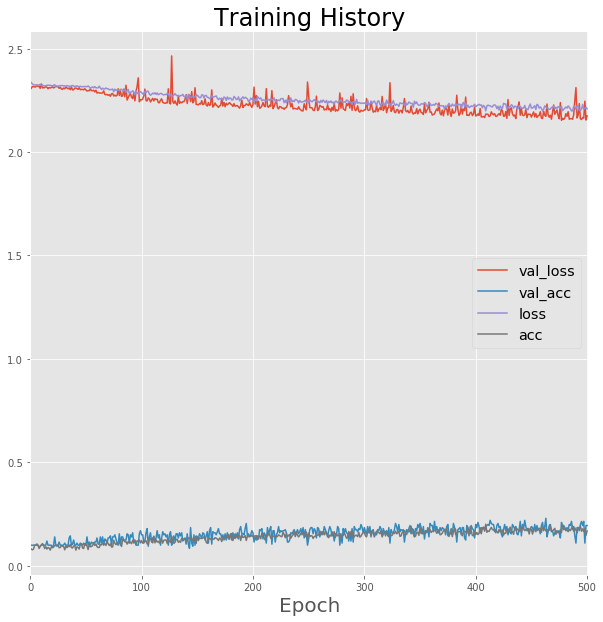

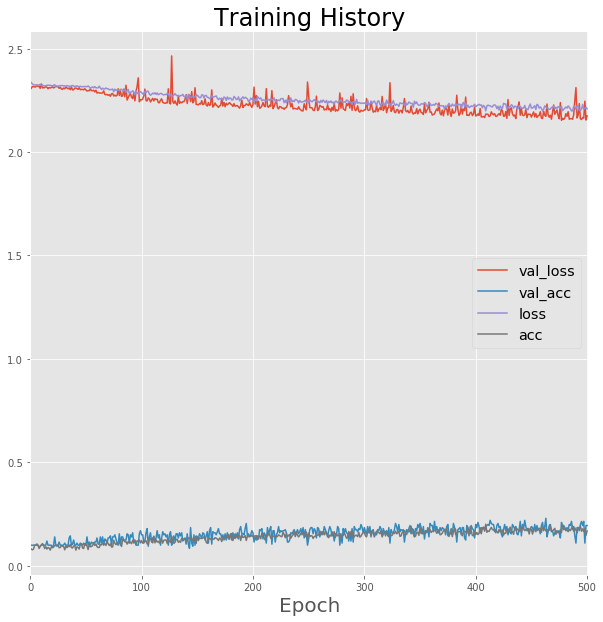

In [21]:
from corebreakout.utils.models_utils import make_training_fig

make_training_fig(history.history)

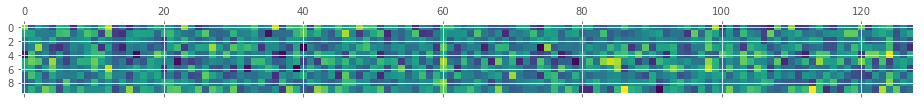

In [22]:
# Visualize the initial codebook
plt.matshow(img_encode.get_layer('encoding').get_weights()[0]) 

In [25]:
# make the whole network trainable now
for layer in img_encode.layers:
    layer.trainable = True

# start with high learning rate
rms = optimizers.RMSprop(lr=0.01)
img_encode.compile(optimizer=rms,
            loss='categorical_crossentropy',
            metrics=['accuracy'])

img_encode.load_weights('./benchmark_models/flickr_vgg19_k32_d128.hdf5')

In [26]:
epochs = 500
batch_size = 8  # try smaller batch size, see if convergence is faster

CHKPT_PATH = './benchmark_models/flickr_vgg19_k10_d128.hdf5'
checkpoint = ModelCheckpoint(CHKPT_PATH, monitor='val_loss', save_best_only=True)
early_stop = EarlyStopping(monitor='val_loss', patience=50)

train_flow = train_gen.flow(X_train, y_train, batch_size=batch_size)
val_flow = val_gen.flow(X_val, y_val, batch_size=batch_size)

# Training
history = img_encode.fit_generator(train_flow,
                        steps_per_epoch=len(X_train)/batch_size,
                        validation_data=val_flow,
                        validation_steps=len(X_val)/batch_size,
                        callbacks=[early_stop, checkpoint], verbose=1, epochs=epochs)

Epoch 1/500
100/100 [==============================] - 39s 386ms/step - loss: 2.3156 - acc: 0.1013 - val_loss: 2.3052 - val_acc: 0.1000
Epoch 2/500
100/100 [==============================] - 34s 338ms/step - loss: 2.3074 - acc: 0.0900 - val_loss: 2.3031 - val_acc: 0.1000
Epoch 3/500
100/100 [==============================] - 34s 342ms/step - loss: 2.3078 - acc: 0.0813 - val_loss: 2.3029 - val_acc: 0.1000
Epoch 4/500
100/100 [==============================] - 34s 336ms/step - loss: 2.3074 - acc: 0.0862 - val_loss: 2.3027 - val_acc: 0.1000
Epoch 5/500
100/100 [==============================] - 34s 344ms/step - loss: 2.3074 - acc: 0.0875 - val_loss: 2.3028 - val_acc: 0.1000
Epoch 6/500
100/100 [==============================] - 34s 340ms/step - loss: 2.3067 - acc: 0.0950 - val_loss: 2.3029 - val_acc: 0.1000
Epoch 7/500
100/100 [==============================] - 34s 340ms/step - loss: 2.3073 - acc: 0.0850 - val_loss: 2.3029 - val_acc: 0.1000
Epoch 8/500
100/100 [===========================

KeyboardInterrupt: 

fabric


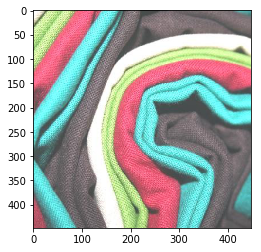

fabric


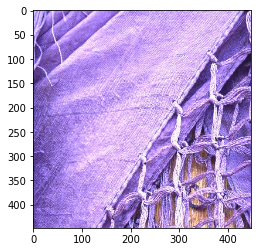

foliage


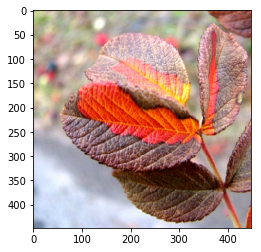

foliage


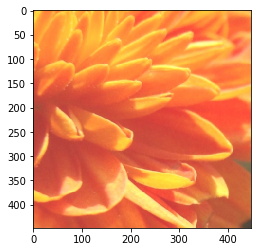

glass


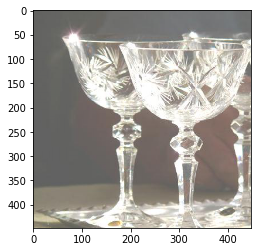

glass


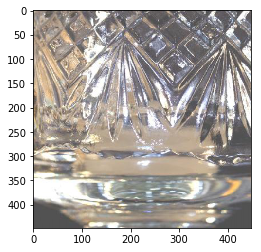

leather


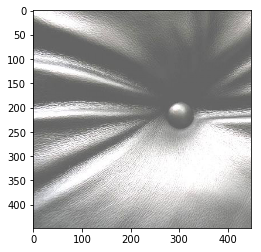

leather


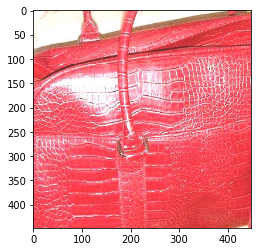

metal


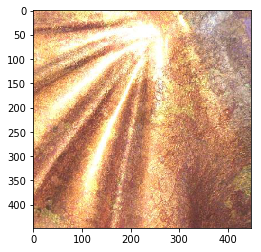

metal


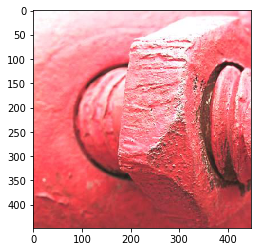

paper


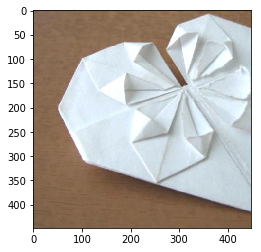

paper


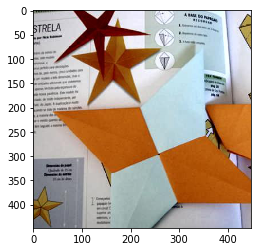

plastic


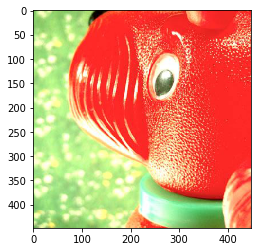

plastic


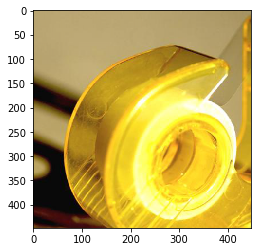

stone


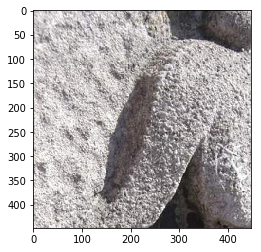

stone


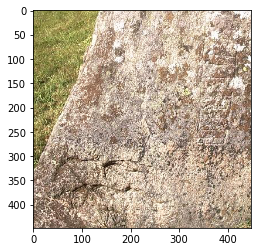

water


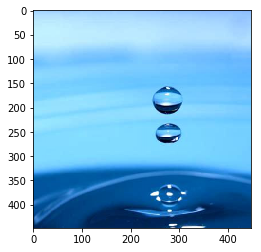

water


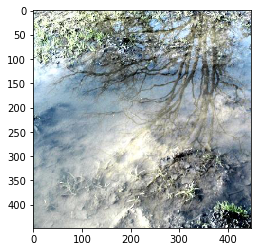

wood


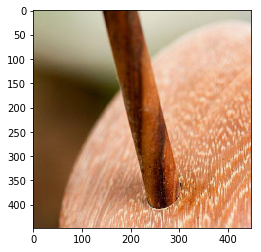

wood


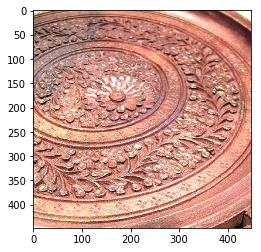

In [57]:
for i in range(0, 1000, 50):
    print(classes[y[i]])
    plt.imshow(X[i,...])
    plt.show()

In [38]:
t = K.variable(np.random.randint(0, 10, (3,4,4)))
w = K.variable(np.random.randint(0, 10, (4,4)))

In [31]:
mult = layers.Multiply()

In [33]:
import tensorflow as tf

In [39]:
out = tf.multiply(t, w)

In [40]:
K.eval(t), K.eval(w), K.eval(out)

(array([[[8., 0., 9., 4.],
         [3., 9., 2., 6.],
         [7., 3., 5., 3.],
         [3., 7., 8., 9.]],
 
        [[9., 3., 5., 2.],
         [0., 2., 2., 3.],
         [3., 6., 5., 8.],
         [8., 7., 7., 7.]],
 
        [[5., 9., 3., 3.],
         [9., 8., 9., 1.],
         [7., 1., 7., 8.],
         [7., 1., 9., 8.]]], dtype=float32), array([[0., 2., 8., 0.],
        [3., 2., 0., 9.],
        [5., 1., 3., 2.],
        [4., 7., 5., 5.]], dtype=float32), array([[[ 0.,  0., 72.,  0.],
         [ 9., 18.,  0., 54.],
         [35.,  3., 15.,  6.],
         [12., 49., 40., 45.]],
 
        [[ 0.,  6., 40.,  0.],
         [ 0.,  4.,  0., 27.],
         [15.,  6., 15., 16.],
         [32., 49., 35., 35.]],
 
        [[ 0., 18., 24.,  0.],
         [27., 16.,  0.,  9.],
         [35.,  1., 21., 16.],
         [28.,  7., 45., 40.]]], dtype=float32))